In [1]:
# Author: Ruudra Patel

# Install and start Spark in Colab
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark pyspark matplotlib seaborn

import os, findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"
findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import year
import matplotlib.pyplot as plt
import seaborn as sns

# Create Spark Session
spark = SparkSession.builder \
    .appName("MovieLens Analysis") \
    .getOrCreate()

print("Spark Session Started")

Spark Session Started


In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Path to dataset folder
DATA_PATH = "/content/drive/MyDrive/movielens/"  # change if needed

# Load CSVs
ratings_df = spark.read.csv(DATA_PATH + "rating.csv", header=True, inferSchema=True)
movies_df = spark.read.csv(DATA_PATH + "movie.csv", header=True, inferSchema=True)
tags_df = spark.read.csv(DATA_PATH + "tag.csv", header=True, inferSchema=True)

ratings_df.show(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|      2|   3.5|2005-04-02 23:53:47|
|     1|     29|   3.5|2005-04-02 23:31:16|
|     1|     32|   3.5|2005-04-02 23:33:39|
|     1|     47|   3.5|2005-04-02 23:32:07|
|     1|     50|   3.5|2005-04-02 23:29:40|
+------+-------+------+-------------------+
only showing top 5 rows



## Insight 1: Average Movie Ratings by Genre

**Objective:** To determine the average rating for movies across different genres.

**Business/Analytical Value:** This insight can help identify genres that are generally well-received by users, which can inform content acquisition strategies or recommendations.

<>:2: SyntaxWarning: invalid escape sequence '\|'
<>:2: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-3087626783.py:2: SyntaxWarning: invalid escape sequence '\|'
  movies_exploded = movies_df.withColumn("genre", explode(split(col("genres"), "\|")))
/tmp/ipython-input-3087626783.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_rating", y="genre", data=genre_pd, palette="viridis")


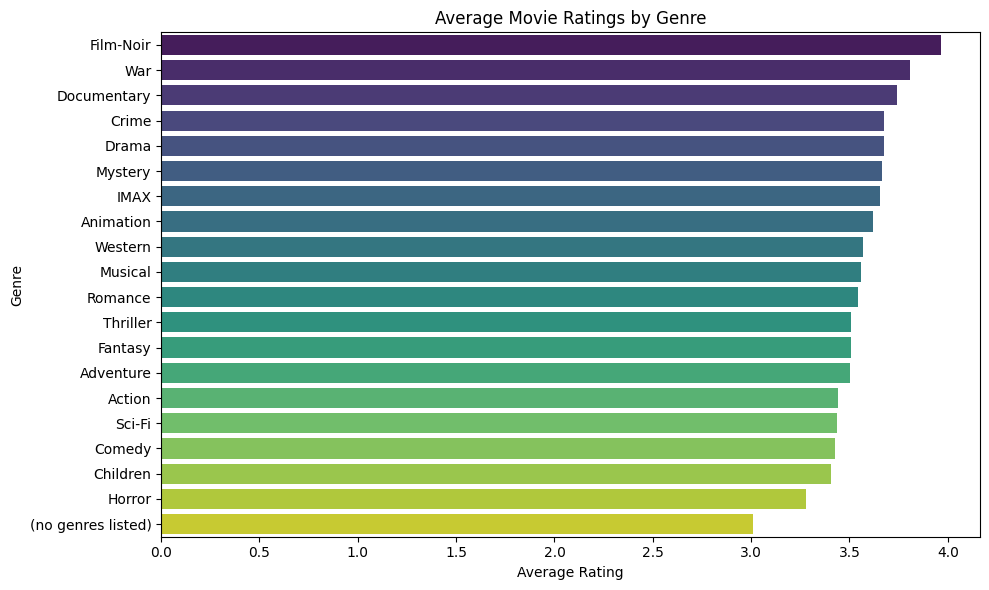

In [5]:
# Split genres (some movies have multiple genres separated by '|')
movies_exploded = movies_df.withColumn("genre", explode(split(col("genres"), "\|")))

# Join with ratings
ratings_with_genre = ratings_df.join(movies_exploded, "movieId")

# Compute average rating by genre
genre_ratings = ratings_with_genre.groupBy("genre").agg(avg("rating").alias("avg_rating")).orderBy(desc("avg_rating"))

# Convert to Pandas for plotting
genre_pd = genre_ratings.toPandas()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="avg_rating", y="genre", data=genre_pd, palette="viridis")
plt.title("Average Movie Ratings by Genre")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.tight_layout()
plt.savefig("insight1_avg_ratings_by_genre.png")
plt.show()

## Insight 2: Rating Trends Over Time

**Objective:** To visualize how the number of movie ratings has changed over the years.

**Business/Analytical Value:** Understanding rating trends can reveal periods of increased user activity or the impact of events (like the release of popular movies or changes in the platform) on user engagement.

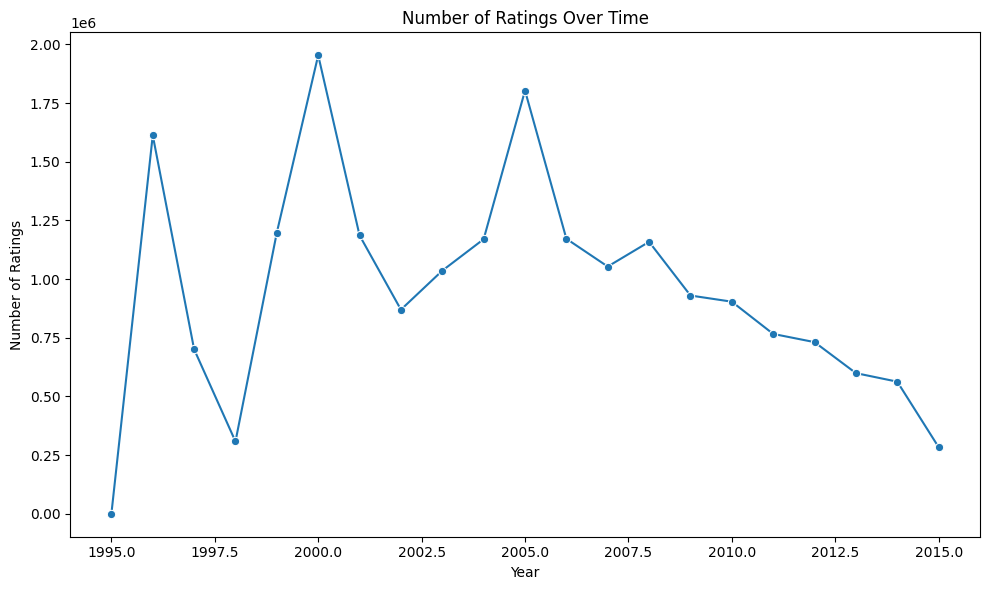

In [6]:
# Extract year directly from the timestamp column
ratings_df = ratings_df.withColumn("year", year(col("timestamp")))

# Count ratings per year
ratings_per_year = ratings_df.groupBy("year").count().orderBy("year")

# Convert Spark DataFrame → Pandas DataFrame
ratings_per_year_pd = ratings_per_year.toPandas()

# Plot using seaborn
plt.figure(figsize=(10,6))
sns.lineplot(x="year", y="count", data=ratings_per_year_pd, marker="o")
plt.title("Number of Ratings Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Ratings")
plt.tight_layout()
plt.savefig("insight2_ratings_trend.png")
plt.show()

## Insight 3: Top 10 Most Rated Movies

**Objective:** To identify the movies with the highest number of ratings.

**Business/Analytical Value:** This insight highlights the most popular movies based on user engagement, which can be valuable for marketing, content promotion, or understanding user preferences.

/tmp/ipython-input-609589812.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="title", data=top_movies_pd, palette="magma")


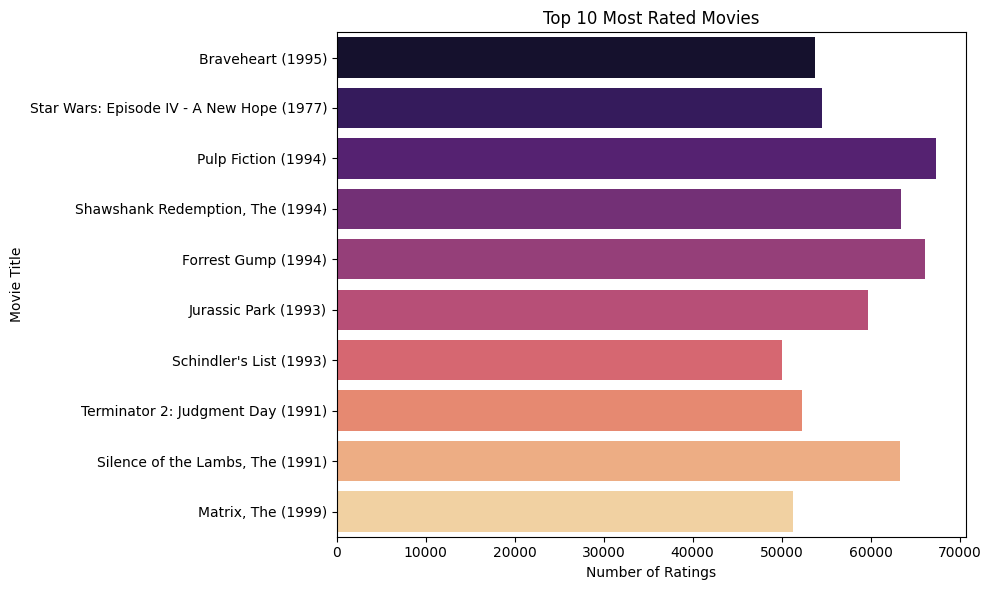

In [7]:
movie_ratings_count = ratings_df.groupBy("movieId").count().orderBy(desc("count")).limit(10)
top_movies = movie_ratings_count.join(movies_df, "movieId").select("title", "count")

top_movies_pd = top_movies.toPandas()

plt.figure(figsize=(10,6))
sns.barplot(x="count", y="title", data=top_movies_pd, palette="magma")
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.tight_layout()
plt.savefig("insight3_top10_movies.png")
plt.show()

In [8]:
!mkdir -p /content/drive/MyDrive/movielens_output
!mv *.png /content/drive/MyDrive/movielens_output/
print("Plots saved to /content/drive/MyDrive/movielens_output/")

Plots saved to /content/drive/MyDrive/movielens_output/
